# Ant Colony Optimization Solver
A implemenation which takes the solvers and the roblem instance then tends to act randomly. It is a good baseline to compare with other solvers.

## Imports all the Libraries
Importing all the libraries which are required for the implementation.

In [26]:
! pip install ipykernel
! pip install Pillow
! pip install matplotlib
! pip install numpy
! pip install pandas
! pip install tqdm
import random
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import time as t
import tqdm as tqdm



## Accessing the Data (Openning it from the CSV file) (Redo of the data_analysis.ipynb)
Checking if the data is loaded correctly, and all the files are there or not.

In [27]:
problems_files = glob.glob('data/*.tsp')
problems = []
for prob in problems_files:
    problems.append(prob[5:])
    #print(prob[5:])

print(problems)

print(len(problems) == 10)


['ch130.tsp', 'd198.tsp', 'eil76.tsp', 'fl1577.tsp', 'kroA100.tsp', 'lin318.tsp', 'pcb442.tsp', 'pr439.tsp', 'rat783.tsp', 'u1060.tsp']
True


## Finding the Euclidean Distance
The distance between points for the edges weights. The distance between two points is the square root of the sum of the squares of the differences of the coordinates.

In [28]:
def euclidean_distance(point_i, point_j):
    rouding = 0
    x_i, y_i = point_i[0], point_i[1]
    x_j, y_j = point_j[0], point_j[1]
    distance = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2)
    return round(distance, rouding)

point_1 = (2, 2)
point_2 = (5, 5)
print(euclidean_distance(point_1, point_2))

4.0


## Reading the Data and Creating the Graph
Reading the data from the CSV file and creating the graph. The graph is created using the networkx library.

In [29]:
class CreatingGraph:
    def __init__(self, problem):
        self.problem = problem
        #self.graph = self.create_graph()

        # reading the raw data from the file
        with open (problem) as f:
            data = f.read()
            self.lines = data.splitlines()

        
        self.name = self.lines[0].split()[2]
        self.type = self.lines[1].split()[2]
        self.dimension = int(self.lines[3].split(' ')[2])
        #self.edge_weight_type = self.lines[4].split()[2]

        self.best_known = float(self.lines[5].split()[2])

        self.point = np.zeros((self.dimension, 3))
        self.distance_matrix = None
        for i in range(self.dimension):
            lines_i = self.lines[i+7].split(' ')
            self.point[i, 0] = int(lines_i[0])
            self.point[i, 1] = float(lines_i[1])
            self.point[i, 2] = float(lines_i[2])
        
        #Creating the Distance Matrix of all the points
        self.distance_matrix = np.zeros((int(self.dimension), int(self.dimension)))
        for i in range(self.dimension):
            for j in range(i, self.dimension):
                self.distance_matrix[i, j] = euclidean_distance(self.point[i][1:3], self.point[j][1:3])
            self.distance_matrix += self.distance_matrix.T
        


    
    def print_metatdata(self):
        print("----------------------------------\n")
        print("Name: ", self.name)
        print("Type: ", self.type)
        print("Dimension: ", self.dimension)
         #print("Edge Weight Type: ", self.edge_weight_type)
        print("Best Known: ", self.best_known)
        print("Distance Matrix: ", self.distance_matrix)
        print("----------------------------------")
        print(self.distance_matrix[0][1])
    
    def plot_data(self):
        plt.scatter(self.point[:,1], self.point[:,2])
        plt.show()

 

## Testing out the Graph
Testing out the graph by printing the nodes and seeing if all the retrieval is fine or not.

----------------------------------

Name:  eil76
Type:  76-city
Dimension:  76
Best Known:  538.0
Distance Matrix:  [[0.00000000e+00 5.66683978e+23 8.68915433e+23 ... 6.80020774e+23
  8.68915433e+23 9.44473297e+23]
 [5.66683978e+23 0.00000000e+00 4.53347182e+23 ... 1.32226262e+23
  2.26673591e+23 2.83341989e+23]
 [8.68915433e+23 4.53347182e+23 0.00000000e+00 ... 2.92786722e+23
  1.98339392e+23 1.88894659e+23]
 ...
 [6.80020774e+23 1.32226262e+23 2.92786722e+23 ... 0.00000000e+00
  6.80000000e+01 8.00000000e+01]
 [8.68915433e+23 2.26673591e+23 1.98339392e+23 ... 6.80000000e+01
  0.00000000e+00 6.00000000e+00]
 [9.44473297e+23 2.83341989e+23 1.88894659e+23 ... 8.00000000e+01
  6.00000000e+00 0.00000000e+00]]
----------------------------------
5.666839779443574e+23


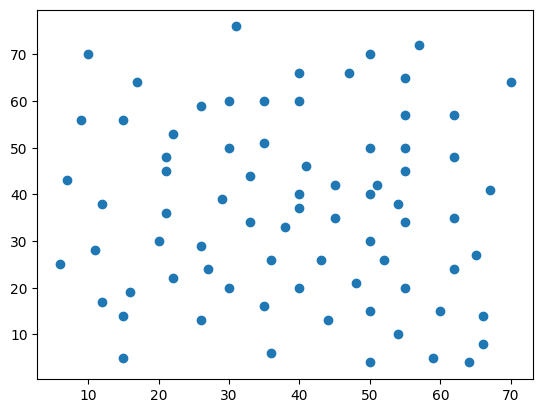

In [90]:
example_problem = "data/eil76.tsp"
problem_instance = CreatingGraph(example_problem)
CreatingGraph(example_problem).print_metatdata()
CreatingGraph(example_problem).plot_data()

## Creating the Ant Colony Optimization Solver

In [89]:
class AntColonyOptimization:
    def __init__(self, problem, alpha, beta, rho, Q, n_ants, n_iterations, n_best, n_rand):
        self.problem = problem
        self.alpha = alpha # pheromone importance
        self.beta = beta # heuristic importance
        self.rho = rho # evaporation rate
        self.Q = Q # pheromone intensity
        self.n_ants = n_ants # number of ants
        self.n_iterations = n_iterations # number of iterations
        self.n_best = n_best # number of best ants
        self.n_rand = n_rand # number of random ants

        self.graph = CreatingGraph(problem)
        self.distance_matrix = self.graph.distance_matrix
        self.dimension = self.graph.dimension
        self.best_known = self.graph.best_known

        self.pheromone_matrix = np.ones((self.dimension, self.dimension))
        self.best_solution = None
        self.best_cost = np.inf
        self.best_solutions = []
        self.best_costs = []
        self.mean_costs = []
        self.elapsed_time = 0

    def _select_next_node(self, current_node, tabu_list):
        p = np.zeros(self.dimension)
        denominator = 0
        for i in range(self.dimension):
            if i not in tabu_list:
                denominator += self.pheromone_matrix[current_node][i]**self.alpha * (1/self.distance_matrix[current_node][i])**self.beta
        for i in range(self.dimension):
            if i not in tabu_list:
                numerator = self.pheromone_matrix[current_node][i]**self.alpha * (1/self.distance_matrix[current_node][i])**self.beta
                p[i] = numerator/denominator
        cum_p = np.cumsum(p)
        r = random.random()
        for i, cum_p_i in enumerate(cum_p):
            if r < cum_p_i:
                return i

    def _construct_solutions(self):
        solutions = []
        for k in range(self.n_ants):
            tabu_list = [0]
            solution = [0]
            while len(tabu_list) < self.dimension:
                next_node = self._select_next_node(solution[-1], tabu_list)
                solution.append(next_node)
                tabu_list.append(next_node)
            solutions.append(solution)
        return solutions

    def _update_pheromone(self, solutions):
        delta_pheromone_matrix = np.zeros((self.dimension, self.dimension))
        for solution in solutions:
            cost = 0
            for i in range(self.dimension- 1):
                cost += self.distance_matrix[solution[i]][solution[i+1]]
            cost += self.distance_matrix[solution[-1]][solution[0]]
            for i in range(self.dimension-1):
                delta_pheromone_matrix[solution[i]][solution[i+1]] += self.Q/cost
                delta_pheromone_matrix[solution[i+1]][solution[i]] += self.Q/cost
            delta_pheromone_matrix[solution[-1]][solution[0]] += self.Q/cost
            delta_pheromone_matrix[solution[0]][solution[-1]] += self.Q/cost
        self.pheromone_matrix = (1-self.rho)*self.pheromone_matrix + delta_pheromone_matrix
    
    def _update_best(self, solutions):
        for solution in solutions:
            cost = 0
            for i in range(self.dimension-1):
                cost += self.distance_matrix[solution[i]][solution[i+1]]
            cost += self.distance_matrix[solution[-1]][solution[0]]
            if cost < self.best_cost:
                self.best_cost = cost
                self.best_solution = solution
        self.best_solutions.append(self.best_solution)
        self.best_costs.append(self.best_cost)
        self.mean_costs.append(np.mean(self.best_costs[-self.n_best:]))
    
    def _local_search(self, solution):
        for i in range(self.n_rand):
            r1 = random.randint(1, self.dimension-1)
            r2 = random.randint(1, self.dimension-1)
            solution[r1], solution[r2] = solution[r2], solution[r1]
        return solution
    
    def _local_search_all(self, solutions):
        for i, solution in enumerate(solutions):
            solutions[i] = self._local_search(solution)
        return solutions
    
    def _two_opt(self, solution):
        for i in range(1, self.dimension-2):
            for j in range(i+1, self.dimension):
                if j-i == 1:
                    continue
                solution[i:j] = solution[j-1:i-1:-1]
                return solution
    
    def _three_opt(self, solution):
        for i in range(1, self.dimension-3):
            for j in range(i+1, self.dimension-2):
                for k in range(j+1, self.dimension-1):
                    if k-j == 1 or j-i == 1:
                        continue
                    solution[i:j] = solution[j-1:i-1:-1]
                    solution[j:k] = solution[k-1:j-1:-1]
                    return solution

    def length_of_the_path(self):
        cost = 0
        for i in range(self.dimension-1):
            cost += self.distance_matrix[self.best_solution[i]][self.best_solution[i+1]]
        cost += self.distance_matrix[self.best_solution[-1]][self.best_solution[0]]
        return cost
    
    def solve(self):
        start_time = t()
        for i in range(self.n_iterations):
            solutions = self._construct_solutions()
            solutions = self._local_search_all(solutions)
            self._update_pheromone(solutions)
            self._update_best(solutions)
            #priting the Best Cost and Best Solution
            print('Iteration: {}, Best Cost: {}'.format(i+1, self.best_cost), 'Length of the Path: {}'.format(self.length_of_the_path()))
        self.elapsed_time = t() - start_time
        self.best_solution = self._two_opt(self.best_solution)
        self.best_solution = self._three_opt(self.best_solution)
        return self.best_solution, self.best_cost
    
    

    def plot(self):
        plt.plot(self.best_costs, label="Best")
        plt.plot(self.mean_costs, label="Mean")
        plt.legend()
        plt.show()
    
    def print_results(self):
        print("Length of the Path", self.length_of_the_path())
        print("Best solution: ", self.best_solution)
        print("Best cost: ", self.best_cost)
        print("Best known: ", self.best_known)
        print("Elapsed time: ", self.elapsed_time)
    
    def plot_best_solution(self):
        x = [self.graph.point[i][1] for i in self.best_solution]
        y = [self.graph.point[i][2] for i in self.best_solution]
        plt.plot(x, y, 'o-')
        plt.show()
    

    


### Testing the Ant Colony Optimization Solver

Iteration: 1, Best Cost: 1.826134362882587e+24
Iteration: 2, Best Cost: 1.7961857069683085e+24
Iteration: 3, Best Cost: 1.7150088063023343e+24
Iteration: 4, Best Cost: 1.678031285768654e+24
Iteration: 5, Best Cost: 1.678031285768654e+24
Iteration: 6, Best Cost: 1.678031285768654e+24
Iteration: 7, Best Cost: 1.678031285768654e+24
Iteration: 8, Best Cost: 1.678031285768654e+24
Iteration: 9, Best Cost: 1.678031285768654e+24
Iteration: 10, Best Cost: 1.678031285768654e+24
Iteration: 11, Best Cost: 1.678031285768654e+24
Iteration: 12, Best Cost: 1.6699191646352603e+24
Iteration: 13, Best Cost: 1.6519314451878925e+24
Iteration: 14, Best Cost: 1.6519314451878925e+24
Iteration: 15, Best Cost: 1.6519314451878925e+24
Iteration: 16, Best Cost: 1.6519314451878925e+24
Iteration: 17, Best Cost: 1.6519314451878925e+24
Iteration: 18, Best Cost: 1.6519314451878925e+24
Iteration: 19, Best Cost: 1.6519314451878925e+24
Iteration: 20, Best Cost: 1.6519314451878925e+24
Iteration: 21, Best Cost: 1.6519314451

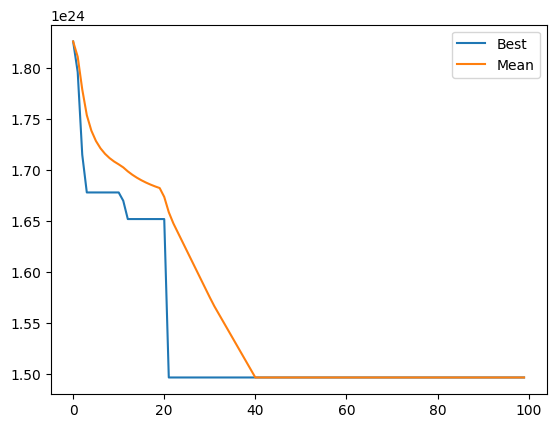

Length of the Path 1.4965309042154474e+24
Best solution:  [0, 72, 75, 73, 74, 44, 25, 7, 69, 27, 66, 12, 65, 63, 62, 22, 11, 59, 58, 30, 56, 54, 55, 51, 52, 53, 49, 50, 47, 70, 48, 26, 71, 45, 40, 41, 13, 39, 61, 36, 37, 57, 34, 31, 35, 32, 33, 46, 28, 23, 2, 43, 64, 24, 38, 4, 21, 15, 16, 17, 18, 42, 19, 14, 67, 60, 8, 9, 5, 3, 20, 68, 6, 10, 29, 1]
Best cost:  1.4965309042154516e+24
Best known:  538.0
Elapsed time:  76.10704493522644


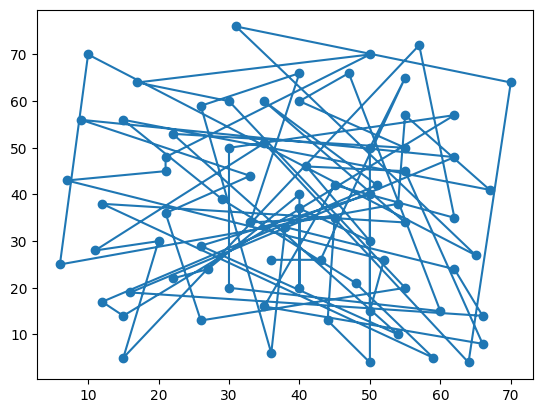

In [88]:
solver_instance = AntColonyOptimization(problem=example_problem, alpha=1.2, beta=1.5, rho=0.5, Q=100, n_ants=100, n_iterations=100, n_best=20, n_rand=20)
#solver_instance._construct_solutions()
solver_instance.solve()
solver_instance.plot()
solver_instance.print_results()
solver_instance.plot_best_solution()


## Testing aco_solver_attempt_1.py

In [93]:
#import aco_solver_attempt_2
import aco_solver_attempt_1

solver_instance_1 = aco_solver_attempt_1.AntColonyOptimization(problem=example_problem, alpha=1.2, beta=1.5, rho=0.5, Q=100, n_ants=100, n_iterations=100, n_best=20, n_rand=20)

TypeError: AntColonyOptimization.__init__() got an unexpected keyword argument 'problem'